<a href="https://colab.research.google.com/github/sepandms/SkinCare/blob/main/CNN_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
G_path = '/content/drive/MyDrive/DataSources/SkinCare/'
G_Aug = '/content/drive/MyDrive/DataSources/SkinCare/Augmented_AutoEncoded/'
G_save = G_path + 'Saved/'
!pip install pickle5

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 256 kB 4.3 MB/s 


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
#import torchvision.transforms.Compose
import numpy as np
from datetime import datetime	
import random
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import random_split
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import DataLoader
import time
from tqdm import tqdm
import pickle as pickle
from statistics import mean
import pandas as pd
import sklearn as sk
from sklearn.model_selection import train_test_split
device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else "cpu")
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')
path = '/Users/sepehrbe/DataSources/Kaggle/SkinCare/Data/Pickle_Data/'
p_models = '/Users/sepehrbe/DataSources/Kaggle/SkinCare/Models/Saved/'

In [3]:
#file = 'test1.pkl' 
file = 'AutoEncoder_input_data' 
try:
    infile = open(G_Aug + file,'rb') # for google colab
except:
    infile = open(path+file,'rb') # for M1
input_data = pickle.load(infile)

file = 'AutoEncoder_labels' 
try:
    infile = open(G_Aug + file,'rb') # for google colab
except:
    infile = open(path+file,'rb') # for M1
labels = pickle.load(infile)

In [17]:
batch_size = 16
training_set = torchvision.datasets.ImageFolder(root = G_Aug + "latent_dataset_train_valid_test20/Training_set", transform = transforms.ToTensor())
validation_set = torchvision.datasets.ImageFolder(root = G_Aug + "latent_dataset_train_valid_test20/Validation_set", transform = transforms.ToTensor())
test_set = torchvision.datasets.ImageFolder(root = G_Aug + "latent_dataset_train_valid_test20/Test_set", transform = transforms.ToTensor())

print(len(training_set))
print(len(validation_set))
print(len(test_set))

x = training_set.imgs
y = training_set.targets

counts = np.bincount(y)
print(counts)
labels_weights = 1. / counts
weights = labels_weights[y]
#weights = weights/sum(weights)
print(set(y))
print(min(weights), " - ", max(weights))
print(weights)
print(len(weights))
w_sampler = WeightedRandomSampler(weights, len(weights))

train_loader = DataLoader(dataset=training_set, sampler=w_sampler, batch_size=batch_size, num_workers=4)
validation_loader = DataLoader(dataset=validation_set, shuffle=True, batch_size=batch_size, num_workers=2)
test_loader = DataLoader(dataset=test_set, shuffle=True, batch_size=batch_size, num_workers=2)

6556
820
820
[4323  491  582  524  156  116  364]
{0, 1, 2, 3, 4, 5, 6}
0.0002313208420078649  -  0.008620689655172414
[0.00023132 0.00023132 0.00023132 ... 0.00274725 0.00274725 0.00274725]
6556


In [52]:
for i, val_data in enumerate(train_loader, 0): val_inputs , val_labels = val_data; break

In [54]:
loader = DataLoader(dataset=trainset)
channels_sum, channels_squared_sum, num_batches = 0, 0, 0
for data, _ in loader:
    channels_sum += torch.mean(data, dim=[0, 2, 3])
    channels_squared_sum += torch.mean(data ** 2, dim=[0, 2, 3])
    num_batches += 1

mean = channels_sum / num_batches
std = (channels_squared_sum / num_batches - mean * 2) * 0.5

#print(mean)
#print(std)

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

train_dataset = torchvision.datasets.CIFAR10(root='dataset/', train=True,
                                             transform=transform, download=True)

16

# **Standardize Train and Validation data**

# **Show some Images**

In [12]:
for i in np.random.choice(input_data[0].shape[0], 3, replace=False):
  print("--------Original Image----------")
  # print('i: ', input_data[0]['image_id'].iloc[i])
  image1 = torch.from_numpy(input_data[0])
  print("Image:{}, target:{}".format(i, labels[0]['image_label'].iloc[i]))
  plt.imshow(image1, interpolation='nearest')
  plt.show()
  print("---------Normilized Image---------")
  print("###################################")

--------Original Image----------


TypeError: ignored

### **1.2 Nets**

In [26]:
class CNN_Nets:

  class Net1(nn.Module):
      def __init__(self):
          super().__init__()
          self.conv1 = nn.Conv2d( in_channels=3 , out_channels=32 , kernel_size=(3, 3))
          self.conv2 = nn.Conv2d( in_channels=32, out_channels=32 , kernel_size=(3, 3))
          self.pool1 = nn.MaxPool2d( kernel_size = (2,2), stride = None, padding = 0 )
          self.conv3 = nn.Conv2d( in_channels=32, out_channels=64 , kernel_size=(3, 3))
          self.conv4 = nn.Conv2d( in_channels=64, out_channels=64 , kernel_size=(3, 3))
          self.pool2 = nn.MaxPool2d( kernel_size = (2,2), stride = None, padding = 0 )
          self.fc1   = nn.Linear(in_features= 6144 , out_features = 512)
          self.fc2   = nn.Linear(in_features= 512, out_features = 7)
          self.Act   = nn.ReLU(inplace=True)
      def forward(self, x):
          out = self.Act(self.conv1(x))
          out = self.Act(self.conv2(out))
          out = self.Act(self.pool1(out))
          out = self.Act(self.conv3(out))
          out = self.Act(self.conv4(out))
          out = self.Act(self.pool2(out))
          out = torch.flatten(out, 1) 
          out = self.Act(self.fc1(out))
          out = self.Act(self.fc2(out))
          # out = nn.Softmax(out)
          return out

  class Net2(nn.Module):
      def __init__(self):
          super().__init__()
          self.conv1 = nn.Conv2d( in_channels=3 , out_channels=32 , kernel_size=(3, 3))
          self.pool1 = nn.MaxPool2d( kernel_size = (2,2), stride = None, padding = 0 )
          self.conv3 = nn.Conv2d( in_channels=32, out_channels=64 , kernel_size=(3, 3))
          self.pool2 = nn.MaxPool2d( kernel_size = (2,2), stride = None, padding = 0 )
          self.fc1   = nn.Linear(in_features= 7488 , out_features = 512)
          self.fc2   = nn.Linear(in_features= 512, out_features = 7)
          self.Act   = nn.ReLU(inplace=True)
      def forward(self, x):
          out = self.Act(self.conv1(x))
          out = self.Act(self.pool1(out))
          out = self.Act(self.conv3(out))
          out = self.Act(self.pool2(out))
          out = torch.flatten(out, 1) 
          out = self.Act(self.fc1(out))
          out = self.Act(self.fc2(out))
          return out

  class Net3(nn.Module):
      def __init__(self):
          super().__init__()
          self.conv1 = nn.Conv2d( in_channels=3 , out_channels=16 , kernel_size=(3, 3))
          self.pool1 = nn.MaxPool2d( kernel_size = (3,3), stride = None, padding = 0 )
          self.conv2 = nn.Conv2d( in_channels=16, out_channels=24 , kernel_size=(3, 3))
          self.pool2 = nn.MaxPool2d( kernel_size = (3,3), stride = None, padding = 0 )
          self.fc1   = nn.Linear(in_features= 15840 , out_features = 256)
          self.fc2   = nn.Linear(in_features= 256, out_features = 7)
          self.Act   = nn.LeakyReLU(inplace=True)
          self.dropout = nn.Dropout(0.3)
      def forward(self, x):
          out = self.Act(self.conv1(x))
          out = self.Act(self.pool1(out))
          out = self.dropout(out)
          out = self.Act(self.conv2(out))
          out = self.Act(self.pool2(out))
          out = self.dropout(out)
          out = torch.flatten(out, 1) 
          out = self.Act(self.fc1(out))
          out = self.fc2(out)
          return out
      def forward_noDrop(self, x):
          out = self.Act(self.conv1(x))
          out = self.Act(self.pool1(out))
          out = self.Act(self.conv2(out))
          out = self.Act(self.pool2(out))
          out = torch.flatten(out, 1) 
          out = self.Act(self.fc1(out))
          out = self.fc2(out)
          return out

  class Net4(nn.Module):
      def __init__(self):
          super().__init__()
          self.conv1 = nn.Conv2d( in_channels=3 , out_channels=16 , kernel_size=(3, 3))
          self.pool1 = nn.MaxPool2d( kernel_size = (3,3), stride = 1, padding = 0 )
          self.conv2 = nn.Conv2d( in_channels=16, out_channels=24 , kernel_size=(3, 3))
          self.pool2 = nn.MaxPool2d( kernel_size = (3,3), stride = 1, padding = 0 )
          self.fc1   = nn.Linear(in_features= 46176 , out_features = 256)
          self.fc2   = nn.Linear(in_features= 256, out_features = 7)
          self.Act   = nn.LeakyReLU(inplace=True)
          self.dropout = nn.Dropout(0.3)
      def forward(self, x):
          out = self.Act(self.conv1(x))
          out = self.Act(self.pool1(out))
          out = self.dropout(out)
          out = self.Act(self.conv2(out))
          out = self.Act(self.pool2(out))
          out = self.dropout(out)
          out = torch.flatten(out, 1) 
          out = self.Act(self.fc1(out))
          out = self.fc2(out)
          return out

  class Net5(nn.Module):
      def __init__(self):
          super().__init__()
          self.conv1 = nn.Conv2d( in_channels=3 , out_channels=24 , kernel_size=(3, 3))
          self.pool1 = nn.MaxPool2d( kernel_size = (3,3), stride = 1, padding = 0 )
          self.fc1   = nn.Linear(in_features= 55104 , out_features = 7)
          self.Act   = nn.LeakyReLU(inplace=True)
          self.dropout = nn.Dropout(0.3)
      def forward(self, x):
          out = self.Act(self.conv1(x))
          out = self.Act(self.pool1(out))
          out = self.dropout(out)
          out = torch.flatten(out, 1) 
          out = self.fc1(out)
          return out

  class Net6(nn.Module):
      def __init__(self):
          super().__init__()
          self.conv1 = nn.Conv2d( in_channels=3 , out_channels=24 , kernel_size=(3, 3))
          self.pool1 = nn.MaxPool2d( kernel_size = (3,3), stride = 1, padding = 0 )
          self.fc1   = nn.Linear(in_features= 55104 , out_features = 256)
          self.fc2   = nn.Linear(in_features= 256 , out_features = 7)
          self.Act   = nn.LeakyReLU(inplace=True)
          self.dropout = nn.Dropout(0.3)
      def forward(self, x):
          out = self.Act(self.conv1(x))
          out = self.Act(self.pool1(out))
          out = self.dropout(out)
          out = torch.flatten(out, 1) 
          out = self.Act(self.fc1(out))
          out = self.fc2(out)
          return out

# **Test Nets**

In [16]:
model_test = CNN_Nets.Net3()
X_ = input_data[0][0:5]
out = model_test(X_)
out.shape

torch.Size([5, 7])

# **Confusion-Matrix & Accuracy**

In [17]:
def confusion_matrix(Y,Y_pred):
    CM = sk.metrics.confusion_matrix(Y,Y_pred)
    print('Nr. of Data : \n', CM.sum())
    print('Accuracy of The Model : \n', np.diag(CM).sum()/CM.sum())
    # print('Confusion Matrix : \n', CM)
    # print('Weighted Avg. of sensitivity : \n', np.average(np.nan_to_num(sensitivity), weights=weights))
    # print('Weighted Avg. of specificity : \n', np.average(np.nan_to_num(specificity), weights=weights))
    sk.metrics.ConfusionMatrixDisplay(CM).plot()
    # print('------- Precision recal %--------')
    # print(sk.metrics.classification_report(Y,Y_pred))
    # print('------- confusion matrix--------')

    FP = CM.sum(axis=0) - np.diag(CM) 
    FN = CM.sum(axis=1) - np.diag(CM)
    TP = np.diag(CM)
    TN = CM.sum() - (FP + FN + TP)
    weights = CM.sum(axis=1) / CM.sum() 
    ACC = np.nan_to_num((TP+TN)/(TP+FP+FN+TN) , nan=0)
    Recall_Sensitivity = np.nan_to_num(TP/(TP+FN) , nan=0)
    Specificity = np.nan_to_num(TN/(TN+FP) , nan=0)
    Precision = np.nan_to_num(TP/(TP+FP) , nan=0)
    f1_score = np.nan_to_num( 2*Precision*Recall_Sensitivity / (Recall_Sensitivity + Precision), nan=0)
    Performance_DF = pd.concat([pd.DataFrame(CM),pd.DataFrame(weights, columns=['weights']),pd.DataFrame(Precision, columns=['Precision']),pd.DataFrame(Recall_Sensitivity,columns=['Recall_Sensitivity'])
        ,pd.DataFrame(Specificity, columns=['Specificity']),pd.DataFrame(f1_score, columns=['f1_score'])], axis=1)
    total_row1 = pd.Series({'Precision':mean(Precision),'Recall_Sensitivity':mean(Recall_Sensitivity),'Specificity':mean(Specificity),'f1_score':mean(f1_score)}, name='Simple Avg.')
    total_row2 = pd.Series({'Precision':sum(weights*Precision),'Recall_Sensitivity':sum(weights*Recall_Sensitivity),'Specificity':sum(weights*Specificity),'f1_score':sum(weights*f1_score)}, name='Weighted Avg.')
    Performance_DF = Performance_DF.append([total_row1,total_row2])
    cols = ['weights','Precision','Recall_Sensitivity','Specificity','f1_score']
    per_details = Performance_DF[cols].style.format({'weights': "{:.1%}",'Precision': "{:.1%}",'Recall_Sensitivity': "{:.1%}",'Specificity': "{:.1%}",'f1_score': "{:.1%}"})
    return per_details

### **1.3 Training**

In [18]:
class Model_Training:

    def __init__(self, Net, LR, batch_size , Momentum, epochs, weight_decay, loss_func, opt_func, X_train, Y_train, X_valid, Y_valid, print_epochs,hyper_params):    
        
        self.model = Net().to(device)
        if opt_func is torch.optim.Adam:
            self.opt = opt_func(self.model.parameters(), lr=LR, weight_decay=weight_decay)
        else:
            self.opt = opt_func(self.model.parameters(), lr=LR,momentum=Momentum, weight_decay=weight_decay)

        self.loss_func = loss_func()
        self.epochs = epochs
        self.print_epochs = print_epochs
        self.X_train = X_train.to(device)
        self.Y_train = Y_train.to(device)
        self.X_valid = X_valid.to(device)
        self.Y_valid = Y_valid.to(device)
        self.batch_size = batch_size
        self.Epochs_Train_loss = []
        self.Epochs_Train_Acc = []
        self.Epochs_Val_loss = []
        self.Epochs_Val_Acc = []
        self.hyper_params = hyper_params

    def train(self):
        
        model = self.model
        loss_fn = self.loss_func
        opt = self.opt 
        batch_size = self.batch_size
        nr_of_steps_train =  self.X_train.shape[0]//self.batch_size 
        nr_of_steps_valid =  self.X_valid.shape[0]//self.batch_size 

        for epoch in range(1, self.epochs+1 ):
            start_time=time.time()
            steps_train_loss = []
            steps_train_Acc = []
            steps_val_loss = []
            steps_val_Acc = []

            for i in range(0, nr_of_steps_train ):#train_arrays_std.shape[0]):
                X = self.X_train[i* batch_size:(i+1) * batch_size]
                Y = self.Y_train[i * batch_size:(i+1) * batch_size]
                opt.zero_grad()
                model.train()
                y_pred = model.forward(X)
                loss = loss_fn(y_pred, Y)
                loss.backward()
                opt.step()
                y_pred_labels = y_pred.argmax(axis=1)
                nr_of_corrects = (y_pred_labels == Y).sum().item()
                step_acc = nr_of_corrects / batch_size
                steps_train_Acc.append(step_acc)
                steps_train_loss.append(loss.item())

                # if (i+1) % 200 == 0:    # print every 2000 mini-batches
                #     print('[Epoch: {}, Nr. Batch: {}]  , Train-Steps-loss: {:.1f} , running_acc: {:.1%}'.format(epoch , i+1 , train_steps_loss , batch_nr_correct / train_nr_total))
                #     self.train_steps_acc = []
                #     train_steps_loss = 0

              #validation loss calculation
            for j in range(0,nr_of_steps_valid):

                val_X = self.X_valid[j*batch_size:(j+1)*batch_size]
                val_Y = self.Y_valid[j*batch_size:(j+1)*batch_size]
                model.eval()
                # val_inputs = val_inputs.to(device)
                # val_labels = val_labels.to(device)
                val_outputs = model(val_X)
                val_loss = loss_fn(val_outputs, val_Y)
                val_epoch_loss = val_loss.item()
                val_outputs_lbs= val_outputs.argmax(axis=1)
                val_nr_correct = (val_outputs_lbs == val_Y).sum().item()
                step_acc = val_nr_correct / batch_size
                steps_val_Acc.append(step_acc)
                steps_val_loss.append(val_epoch_loss)
            
            # Epoch Performance Metrics
            train_epoch_loss = mean(steps_train_loss)
            train_epoch_Acc = mean(steps_train_Acc)
            self.Epochs_Train_loss.append(train_epoch_loss)
            self.Epochs_Train_Acc.append(train_epoch_Acc)   
            val_epoch_loss = mean(steps_val_loss)
            val_epoch_Acc = mean(steps_val_Acc)
            self.Epochs_Val_loss.append(val_epoch_loss)
            self.Epochs_Val_Acc.append(val_epoch_Acc)
            End_time = time.time() 
            if self.print_epochs:
                print('[Epoch: {}]  , Train_loss: {:.1f} , Train_Acc: {:.1%}, Val_loss: {:.1f} , Val_Acc: {:.1%} , run time: {}'.format(epoch , train_epoch_loss , train_epoch_Acc , val_epoch_loss , val_epoch_Acc, np.round(End_time - start_time, 2)))
            
        # print('Finished Training')

# **Define Training data**

In [20]:
X_train = input_data[0]
Y_train = labels[0]
X_valid = input_data[1]
Y_valid = labels[1]
X_test = input_data[2]
Y_test = labels[2]

# **Model by Grid**

In [ ]:
# Net = [CNN_Net3,CNN_Net4,CNN_Net5,CNN_Net6]
# LR = [ 5e-2,1e-3,1.5e-3,2e-3,1e-4]#,0.0025,0.003]
# batch_size = [32,50]
# Momentum = [0.7,0.75,0.8,0.85,0.9,0.95]
# epochs = [60]
# weight_decay = [0,1e-5,1e-6,1e-7]
# loss_func  =  [nn.CrossEntropyLoss]
# opt_func = [torch.optim.SGD]

Net = [CNN_Net3]
LR = [ 2e-3,2.2e-3]#,0.0025,0.003]
batch_size = [30]
Momentum = [0.82,0.85]
epochs = [75,120]
weight_decay = [1e-7]
loss_func  =  [nn.CrossEntropyLoss]
opt_func = [torch.optim.SGD]


grid = {
    'Net' : Net
    ,'LR' : LR
    ,'batch_size' : batch_size
    ,'Momentum' : Momentum
    ,'epochs' : epochs
    ,'weight_decay' :weight_decay
    ,'loss_func'  :loss_func
    ,'opt_func' : opt_func
}
params = sk.model_selection.ParameterGrid(grid)

In [ ]:
Hyper_Details = pd.DataFrame(columns=['hyper_param','train_accuracy','valid_accuracy','test_accuracy','train_fscore','valid_fscore','test_fscore','train_precision','valid_precision','test_precision'
                                    ,'train_recall','valid_recall','test_recall'])
                                    
print_epochs = False

pbar = tqdm(params, ncols = 100, desc ="Parameter-Level")
for p in pbar:
    Model_ = Model_Training(**p, X_train = X_train , Y_train = Y_train, X_valid = X_valid , Y_valid= Y_valid, print_epochs = print_epochs,hyper_params=p)
    np.random.seed(0)
    random.seed(0)
    torch.manual_seed(0)
    Model_.train()
    
    model_ = Model_.model.eval()

    # Train
    Y_pred = model_(X_train.to(device)).argmax(axis=1)
    Y = Y_train
    train_accuracy = sk.metrics.accuracy_score(Y_pred.to('cpu'),Y.to('cpu') )

    train_precision, train_recall, train_fscore, m = sk.metrics.precision_recall_fscore_support(Y_pred.to('cpu'),Y.to('cpu'), average = 'weighted')

    # Valid
    Y_pred = model_(X_valid.to(device)).argmax(axis=1)
    Y = Y_valid
    valid_accuracy = sk.metrics.accuracy_score(Y_pred.to('cpu'),Y.to('cpu') )
    valid_precision, valid_recall, valid_fscore, m = sk.metrics.precision_recall_fscore_support(Y_pred.to('cpu'),Y.to('cpu'), average = 'weighted')

    # Test
    Y_pred = model_(X_test.to(device)).argmax(axis=1)
    Y = Y_test
    test_accuracy = sk.metrics.accuracy_score(Y_pred.to('cpu'),Y.to('cpu') )
    test_precision, test_recall, test_fscore, m = sk.metrics.precision_recall_fscore_support(Y_pred.to('cpu'),Y.to('cpu'), average = 'weighted')

    pbar.set_description("Test Accuracy %s" % test_accuracy)

    new_row = pd.Series({'hyper_param':p,'train_accuracy':train_accuracy,'valid_accuracy':valid_accuracy,'test_accuracy':test_accuracy,'train_fscore':train_fscore,'valid_fscore':valid_fscore,'test_fscore':test_fscore
    ,'train_precision':train_precision,'valid_precision':valid_precision,'test_precision':test_precision,'train_recall':train_recall,'valid_recall':valid_recall,'test_recall':test_recall}, name='')
    Hyper_Details = Hyper_Details.append(new_row)

best_one = np.argmax(Hyper_Details.test_fscore)
best_param = Hyper_Details.iloc[best_one]['hyper_param']
best_params = Hyper_Details.sort_values('test_accuracy',ascending=False)['hyper_param'][:4]

Grid_Details = Hyper_Details.sort_values('test_accuracy', ascending=False)

dat_hour = datetime.now().strftime("%d_%b_%Y_%H:%M")

Grid_Details.to_csv(G_save + 'CNN_Grid_Searc_Details_'+ dat_hour+ '.csv')
Model_Grid = Model_Training(**best_param, X_train = X_train, Y_train = Y_train, X_valid = X_valid, Y_valid= Y_valid, print_epochs = print_epochs,hyper_params=best_param)
np.random.seed(0)
random.seed(0)
torch.manual_seed(0)
Model_Grid.train()

Test Accuracy 0.6527331189710611: 100%|███████████████████████████████| 8/8 [03:28<00:00, 26.07s/it]


In [ ]:
{'LR': 0.002, 'Momentum': 0.85, 'Net': <class '__main__.CNN_Net3'>, 'batch_size': 32, 'epochs': 60, 'loss_func': <class 'torch.nn.modules.loss.CrossEntropyLoss'>, 'opt_func': <class 'torch.optim.sgd.SGD'>, 'weight_decay': 1e-07}

In [ ]:
Grid_Details['test_accuracy'][:5], Grid_Details['hyper_param'][0]

(    0.668810
     0.665595
     0.665595
     0.655949
     0.652733
 Name: test_accuracy, dtype: float64,
 {'LR': 0.002,
  'Momentum': 0.9,
  'Net': __main__.CNN_Net4,
  'batch_size': 32,
  'epochs': 80,
  'loss_func': torch.nn.modules.loss.CrossEntropyLoss,
  'opt_func': torch.optim.sgd.SGD,
  'weight_decay': 1e-06})

In [ ]:
Grid_Details['test_accuracy'][:5], Grid_Details['hyper_param'][0]

(    0.665595
     0.655949
     0.655949
     0.652733
     0.652733
 Name: test_accuracy, dtype: float64,
 {'LR': 0.002,
  'Momentum': 0.85,
  'Net': __main__.CNN_Net3,
  'batch_size': 30,
  'epochs': 120,
  'loss_func': torch.nn.modules.loss.CrossEntropyLoss,
  'opt_func': torch.optim.sgd.SGD,
  'weight_decay': 1e-07})

In [ ]:
for i in best_params: print(i)

{'LR': 0.001, 'Momentum': 0.75, 'Net': <class '__main__.CNN_Net6'>, 'batch_size': 32, 'epochs': 50, 'loss_func': <class 'torch.nn.modules.loss.CrossEntropyLoss'>, 'opt_func': <class 'torch.optim.sgd.SGD'>, 'weight_decay': 1e-07}
{'LR': 0.001, 'Momentum': 0.75, 'Net': <class '__main__.CNN_Net6'>, 'batch_size': 32, 'epochs': 50, 'loss_func': <class 'torch.nn.modules.loss.CrossEntropyLoss'>, 'opt_func': <class 'torch.optim.sgd.SGD'>, 'weight_decay': 0}
{'LR': 0.001, 'Momentum': 0.75, 'Net': <class '__main__.CNN_Net6'>, 'batch_size': 48, 'epochs': 50, 'loss_func': <class 'torch.nn.modules.loss.CrossEntropyLoss'>, 'opt_func': <class 'torch.optim.sgd.SGD'>, 'weight_decay': 0}
{'LR': 0.001, 'Momentum': 0.8, 'Net': <class '__main__.CNN_Net6'>, 'batch_size': 48, 'epochs': 50, 'loss_func': <class 'torch.nn.modules.loss.CrossEntropyLoss'>, 'opt_func': <class 'torch.optim.sgd.SGD'>, 'weight_decay': 1e-07}


In [ ]:
for i in best_params: print(i)

{'LR': 0.0015, 'Momentum': 0.85, 'Net': <class '__main__.CNN_Net3'>, 'batch_size': 32, 'epochs': 40, 'loss_func': <class 'torch.nn.modules.loss.CrossEntropyLoss'>, 'opt_func': <class 'torch.optim.sgd.SGD'>, 'weight_decay': 1e-06}
{'LR': 0.0015, 'Momentum': 0.85, 'Net': <class '__main__.CNN_Net3'>, 'batch_size': 32, 'epochs': 40, 'loss_func': <class 'torch.nn.modules.loss.CrossEntropyLoss'>, 'opt_func': <class 'torch.optim.sgd.SGD'>, 'weight_decay': 0}
{'LR': 0.002, 'Momentum': 0.8, 'Net': <class '__main__.CNN_Net3'>, 'batch_size': 32, 'epochs': 40, 'loss_func': <class 'torch.nn.modules.loss.CrossEntropyLoss'>, 'opt_func': <class 'torch.optim.sgd.SGD'>, 'weight_decay': 1e-06}
{'LR': 0.002, 'Momentum': 0.85, 'Net': <class '__main__.CNN_Net3'>, 'batch_size': 32, 'epochs': 40, 'loss_func': <class 'torch.nn.modules.loss.CrossEntropyLoss'>, 'opt_func': <class 'torch.optim.sgd.SGD'>, 'weight_decay': 0}


Nr. of Data : 
 311
Accuracy of The Model : 
 0.6720257234726688


,weights,Precision,Recall_Sensitivity,Specificity,f1_score
0,7.4%,50.0%,43.5%,96.5%,46.5%
1,10.6%,56.8%,63.6%,94.2%,60.0%
2,23.5%,68.0%,69.9%,89.9%,68.9%
3,2.3%,50.0%,42.9%,99.0%,46.2%
4,19.6%,67.4%,50.8%,94.0%,57.9%
5,33.4%,73.7%,83.7%,85.0%,78.4%
6,3.2%,66.7%,60.0%,99.0%,63.2%
Simple Avg.,nan%,61.8%,59.2%,94.0%,60.2%
Weighted Avg.,nan%,66.8%,67.2%,90.5%,66.6%


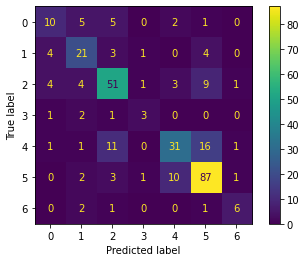

In [ ]:
model_ = Model_Grid.model.eval()
X = input_data[2].to(device)
Y = labels[2].to(device)
Y_pred = model_(X).argmax(dim=1)
confusion_matrix(Y.to('cpu'),Y_pred.to('cpu'))

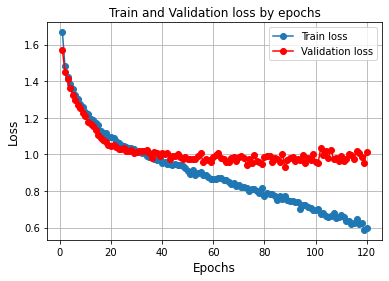

In [ ]:
model_ = Model_Grid
epochs_X = [i for i in range(1, model_.epochs+1)]
epochs_X
plt.subplots(figsize=(6,4))
plt.plot(epochs_X , model_.Epochs_Train_loss, 'o-', label='Train loss')
plt.plot(epochs_X , model_.Epochs_Val_loss,'ro-', label='Validation loss')
plt.xlabel("Epochs", fontsize = 12)
plt.ylabel("Loss", fontsize = 12)
plt.grid()
plt.legend()
plt.title('Train and Validation loss by epochs')
plt.show()

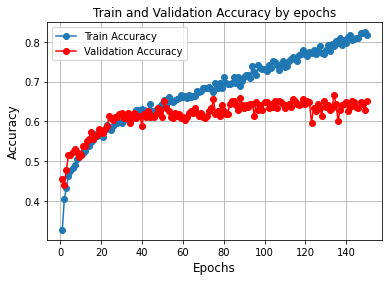

In [ ]:
model_ = Model_Grid
epochs_X = [i for i in range(1, model_.epochs+1)]
epochs_X
plt.subplots(figsize=(6,4))

plt.plot(epochs_X , model_.Epochs_Train_Acc, 'o-', label='Train Accuracy')
plt.plot(epochs_X , model_.Epochs_Val_Acc,'ro-', label='Validation Accuracy')
plt.xlabel("Epochs", fontsize = 12)
plt.ylabel("Accuracy", fontsize = 12)
plt.grid()
plt.legend()
plt.title('Train and Validation Accuracy by epochs')
plt.show()

# **Model by best hyper params with valid and test set**

In [24]:
print_epochs = True

param1 = {'LR': 2e-3,
 'Momentum': 0.85,
 'Net': CNN_Nets.Net3,
 'batch_size': 30,
 'epochs': 20,
 'loss_func': torch.nn.modules.loss.CrossEntropyLoss,
 'opt_func': torch.optim.SGD,
 'weight_decay': 1e-07}

X_train = input_data[0]
Y_train = labels[0]
X_valid = input_data[1]
Y_valid = labels[1]

Model_Best_Grid = Model_Training(**param1,X_train = X_train, Y_train = Y_train, X_valid = X_valid, Y_valid= Y_valid, print_epochs =print_epochs,hyper_params=param1)
np.random.seed(0)
random.seed(0)
torch.manual_seed(0)
Model_Best_Grid.train()

[Epoch: 1]  , Train_loss: 1.1 , Train_Acc: 66.5%, Val_loss: 1.1 , Val_Acc: 68.6% , run time: 3.16
[Epoch: 2]  , Train_loss: 0.9 , Train_Acc: 69.4%, Val_loss: 1.0 , Val_Acc: 68.6% , run time: 2.54
[Epoch: 3]  , Train_loss: 0.9 , Train_Acc: 70.4%, Val_loss: 1.0 , Val_Acc: 69.1% , run time: 2.55
[Epoch: 4]  , Train_loss: 0.8 , Train_Acc: 71.3%, Val_loss: 1.0 , Val_Acc: 69.1% , run time: 2.55
[Epoch: 5]  , Train_loss: 0.8 , Train_Acc: 72.0%, Val_loss: 1.0 , Val_Acc: 68.8% , run time: 2.55
[Epoch: 6]  , Train_loss: 0.8 , Train_Acc: 72.6%, Val_loss: 0.9 , Val_Acc: 69.4% , run time: 2.55
[Epoch: 7]  , Train_loss: 0.8 , Train_Acc: 73.4%, Val_loss: 1.0 , Val_Acc: 68.9% , run time: 2.55
[Epoch: 8]  , Train_loss: 0.7 , Train_Acc: 74.2%, Val_loss: 0.9 , Val_Acc: 69.0% , run time: 2.55
[Epoch: 9]  , Train_loss: 0.7 , Train_Acc: 74.7%, Val_loss: 0.9 , Val_Acc: 70.2% , run time: 2.55
[Epoch: 10]  , Train_loss: 0.7 , Train_Acc: 75.8%, Val_loss: 0.9 , Val_Acc: 68.8% , run time: 2.55
[Epoch: 11]  , Trai

Nr. of Data : 
 820
Accuracy of The Model : 
 0.6963414634146341


,weights,Precision,Recall_Sensitivity,Specificity,f1_score
0,5.6%,46.0%,50.0%,96.5%,47.9%
1,7.9%,41.7%,38.5%,95.4%,40.0%
2,8.9%,39.4%,38.4%,94.2%,38.9%
3,1.8%,12.5%,26.7%,96.5%,17.0%
4,7.4%,34.8%,39.3%,94.1%,36.9%
5,65.9%,87.7%,86.1%,76.8%,86.9%
6,2.4%,25.0%,10.0%,99.2%,14.3%
Simple Avg.,nan%,41.0%,41.3%,93.2%,40.3%
Weighted Avg.,nan%,70.6%,69.6%,83.1%,70.0%


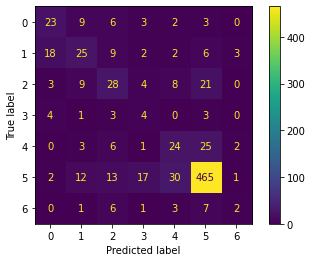

In [28]:
model_ = Model_Best_Grid.model.eval()
X = input_data[2].to(device)
Y = labels[2].to(device)
Y_pred = model_(X).argmax(dim=1)
confusion_matrix(Y.to('cpu'),Y_pred.to('cpu'))

# **K-Fold Cross Validation**

In [ ]:
K_Folds = sk.model_selection.KFold(n_splits=6, shuffle=True)
tensor_subset = torch.utils.data.dataset.Subset

print_epochs = False
# device = 'mps'

CV_data = input_data[3]
CV_label = labels[3]
X_test = input_data[2]
Y_test = labels[2]

# CV_Details_ = pd.DataFrame(columns=['test_fscore','test_precision','test_recall'])

CV_Details = pd.DataFrame(columns=['hyper_param','train_index','valid_index','train_accuracy','valid_accuracy','test_accuracy','train_fscore','valid_fscore','test_fscore','train_precision','valid_precision','test_precision'
                                    ,'train_recall','valid_recall','test_recall'])

pbar = tqdm(best_params, ncols = 100, desc = "Hyper Parameters - Level")

for param in pbar:
# for i in range(1):
    
    for fold, (train_index, valid_index) in enumerate(K_Folds.split(CV_data)):


        X_train = CV_data[train_index]
        Y_train = CV_label[train_index]
        X_valid = CV_data[valid_index]
        Y_valid = CV_label[valid_index]

        # X_train = tensor_subset(input_data[3],train_index).dataset
        # Y_train = tensor_subset(labels[3],train_index).dataset
        # X_valid = tensor_subset(input_data[3],valid_index).dataset
        # Y_valid = tensor_subset(labels[3],valid_index).dataset

        Model_ = Model_Training(**param, X_train = X_train, Y_train = Y_train, X_valid = X_valid, Y_valid= Y_valid, print_epochs = print_epochs,hyper_params=param)
        np.random.seed(0)
        random.seed(0)
        torch.manual_seed(0)
        Model_.train()

        model_ = Model_.model.eval()
            
        # Train
        Y_pred = model_(X_train.to(device)).argmax(axis=1)
        Y = Y_train
        train_accuracy = sk.metrics.accuracy_score(Y_pred.to('cpu'),Y.to('cpu') )
        train_precision, train_recall, train_fscore, m = sk.metrics.precision_recall_fscore_support(Y_pred.to('cpu'),Y.to('cpu') , average = 'weighted')

        # Valid
        Y_pred = model_(X_valid.to(device)).argmax(axis=1)
        Y = Y_valid
        valid_accuracy = sk.metrics.accuracy_score(Y_pred.to('cpu'),Y.to('cpu') )
        valid_precision, valid_recall, valid_fscore, m = sk.metrics.precision_recall_fscore_support(Y_pred.to('cpu'),Y.to('cpu') , average = 'weighted')

        # Test
        Y_pred = model_(X_test.to(device)).argmax(axis=1)
        Y = Y_test
        test_accuracy = sk.metrics.accuracy_score(Y_pred.to('cpu'),Y.to('cpu') )
        test_precision, test_recall, test_fscore, m = sk.metrics.precision_recall_fscore_support(Y_pred.to('cpu'),Y.to('cpu') , average = 'weighted')
        pbar.set_description("Test Accuracy %s" % test_accuracy)
        
        new_row = pd.Series({'hyper_param':param,'train_index':train_index,'valid_index':valid_index,'train_accuracy':train_accuracy,'valid_accuracy':valid_accuracy,'test_accuracy':test_accuracy,'train_fscore':train_fscore,'valid_fscore':valid_fscore,'test_fscore':test_fscore
        ,'train_precision':train_precision,'valid_precision':valid_precision,'test_precision':test_precision,'train_recall':train_recall,'valid_recall':valid_recall,'test_recall':test_recall}, name='')
        CV_Details = CV_Details.append(new_row)

CNN_CV_Details = CV_Details.sort_values('test_accuracy', ascending=False)

Test Accuracy 0.6237942122186495: 100%|██████████████████████████████| 4/4 [10:00<00:00, 150.14s/it]


In [ ]:
CNN_CV_Details['test_accuracy'][:5], CNN_CV_Details['hyper_param'][0]

(    0.662379
     0.655949
     0.649518
     0.649518
     0.649518
 Name: test_accuracy, dtype: float64,
 {'LR': 0.0018,
  'Momentum': 0.85,
  'Net': __main__.CNN_Net4,
  'batch_size': 32,
  'epochs': 80,
  'loss_func': torch.nn.modules.loss.CrossEntropyLoss,
  'opt_func': torch.optim.sgd.SGD,
  'weight_decay': 1e-06})

In [ ]:
CNN_CV_Details['test_accuracy'][:5], CNN_CV_Details['hyper_param'][0]

(    0.652733
     0.649518
     0.646302
     0.643087
     0.643087
 Name: test_accuracy, dtype: float64,
 {'LR': 0.0022,
  'Momentum': 0.82,
  'Net': __main__.CNN_Net3,
  'batch_size': 30,
  'epochs': 75,
  'loss_func': torch.nn.modules.loss.CrossEntropyLoss,
  'opt_func': torch.optim.sgd.SGD,
  'weight_decay': 1e-07})

In [36]:
print_epochs = True
# param = CNN_CV_Details['hyper_param'][0]
# train_index = CNN_CV_Details['train_index'][0]
# valid_index = CNN_CV_Details['valid_index'][0]

# X_train = input_data[3][train_index]
# Y_train = labels[3][train_index]
# X_valid = input_data[3][valid_index]
# Y_valid = labels[3][valid_index]

X_train = input_data[0]
Y_train = labels[0]
X_valid = input_data[1]
Y_valid = labels[1]


param1 = {'LR': 1e-4,
 'Momentum': 0.8,
 'Net': CNN_Nets.Net3,
 'batch_size': 30,
 'epochs': 25,
 'loss_func': torch.nn.modules.loss.CrossEntropyLoss,
 'opt_func': torch.optim.SGD,
 'weight_decay': 1e-07}

Model_CV = Model_Training(**param1,X_train = X_train, Y_train = Y_train, X_valid = X_valid, Y_valid= Y_valid, print_epochs =print_epochs,hyper_params=param1)
np.random.seed(0)
random.seed(0)
torch.manual_seed(0)
Model_CV.train()

RuntimeError: ignored

In [32]:
model_ = Model_CV.model.eval()
X = input_data[2].to(device)
Y = labels[2].to(device)
Y_pred = model_(X).argmax(dim=1)
confusion_matrix(Y.to('cpu'),Y_pred.to('cpu'))

RuntimeError: ignored

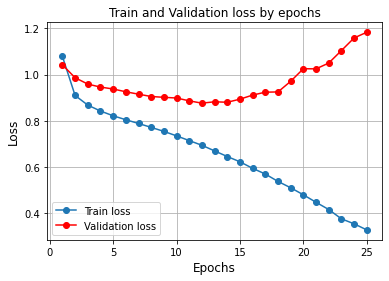

In [33]:
model_ = Model_CV
epochs_X = [i for i in range(1, model_.epochs+1)]
epochs_X
plt.subplots(figsize=(6,4))

plt.plot(epochs_X , model_.Epochs_Train_loss, 'o-', label='Train loss')
plt.plot(epochs_X , model_.Epochs_Val_loss,'ro-', label='Validation loss')
plt.xlabel("Epochs", fontsize = 12)
plt.ylabel("Loss", fontsize = 12)
plt.grid()
plt.legend()
plt.title('Train and Validation loss by epochs')
plt.show()

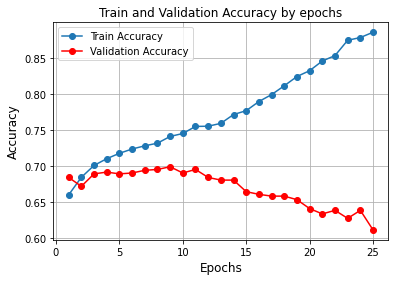

In [34]:
model_ = Model_CV
epochs_X = [i for i in range(1, model_.epochs+1)]
epochs_X
plt.subplots(figsize=(6,4))

plt.plot(epochs_X , model_.Epochs_Train_Acc, 'o-', label='Train Accuracy')
plt.plot(epochs_X , model_.Epochs_Val_Acc,'ro-', label='Validation Accuracy')
plt.xlabel("Epochs", fontsize = 12)
plt.ylabel("Accuracy", fontsize = 12)
plt.grid()
plt.legend()
plt.title('Train and Validation Accuracy by epochs')
plt.show()

# **100 time model training to check Regularization of hyper parameters by Cross Validation**

In [ ]:
K_Folds_test = sk.model_selection.KFold(n_splits=10, shuffle=True)
K_Folds_valid = sk.model_selection.KFold(n_splits=10, shuffle=True)

param1 = {'LR': 2e-3,
 'Momentum': 0.78,
 'Net': CNN_Nets.Net3,
 'batch_size': 30,
 'epochs': 100,
 'loss_func': torch.nn.modules.loss.CrossEntropyLoss,
 'opt_func': torch.optim.SGD,
 'weight_decay': 1e-06}


print_epochs = False
# device = 'mps'

CV_data = input_data[4]
CV_label = labels[4]
# CV_Details_ = pd.DataFrame(columns=['test_fscore','test_precision','test_recall'])

CV_Details = pd.DataFrame(columns=['hyper_param','train_index','valid_index','train_accuracy','valid_accuracy','test_accuracy','train_fscore','valid_fscore','test_fscore','train_precision','valid_precision','test_precision'
                                    ,'train_recall','valid_recall','test_recall'])

# pbar = tqdm(range(10), ncols = 100, desc = "Hyper Parameters - Level")
pbar = tqdm(enumerate(K_Folds_test.split(CV_data)), total=K_Folds_test.get_n_splits(), desc="Test set k-fold",ncols = 100)

for fold, (training_index, test_index) in pbar:
    X_training = CV_data[training_index]
    Y_training = CV_label[training_index]
    X_test = CV_data[test_index]
    Y_test = CV_label[test_index]

    for fold, (train_index, valid_index) in enumerate(K_Folds_valid.split(X_training)):
        X_train = X_training[train_index]
        Y_train = Y_training[train_index]
        X_valid = X_training[valid_index]
        Y_valid = Y_training[valid_index]

        # X_train = tensor_subset(input_data[3],train_index).dataset
        # Y_train = tensor_subset(labels[3],train_index).dataset
        # X_valid = tensor_subset(input_data[3],valid_index).dataset
        # Y_valid = tensor_subset(labels[3],valid_index).dataset

        Model_ = Model_Training(**param1, X_train = X_train, Y_train = Y_train, X_valid = X_valid, Y_valid= Y_valid, print_epochs = print_epochs,hyper_params=param)
        np.random.seed(0)
        random.seed(0)
        torch.manual_seed(0)
        Model_.train()

        model_ = Model_.model.eval()
            
        # Train
        Y_pred = model_(X_train.to(device)).argmax(axis=1)
        Y = Y_train
        train_accuracy = sk.metrics.accuracy_score(Y_pred.to('cpu'),Y.to('cpu') )
        train_precision, train_recall, train_fscore, m = sk.metrics.precision_recall_fscore_support(Y_pred.to('cpu'),Y.to('cpu') , average = 'weighted')

        # Valid
        Y_pred = model_(X_valid.to(device)).argmax(axis=1)
        Y = Y_valid
        valid_accuracy = sk.metrics.accuracy_score(Y_pred.to('cpu'),Y.to('cpu') )
        valid_precision, valid_recall, valid_fscore, m = sk.metrics.precision_recall_fscore_support(Y_pred.to('cpu'),Y.to('cpu') , average = 'weighted')

        # Test
        Y_pred = model_(X_test.to(device)).argmax(axis=1)
        Y = Y_test
        test_accuracy = sk.metrics.accuracy_score(Y_pred.to('cpu'),Y.to('cpu') )
        test_precision, test_recall, test_fscore, m = sk.metrics.precision_recall_fscore_support(Y_pred.to('cpu'),Y.to('cpu') , average = 'weighted')
        pbar.set_description("Test Accuracy %s" % test_accuracy)
        
        new_row = pd.Series({'hyper_param':param,'train_index':train_index,'valid_index':valid_index,'train_accuracy':train_accuracy,'valid_accuracy':valid_accuracy,'test_accuracy':test_accuracy,'train_fscore':train_fscore,'valid_fscore':valid_fscore,'test_fscore':test_fscore
        ,'train_precision':train_precision,'valid_precision':valid_precision,'test_precision':test_precision,'train_recall':train_recall,'valid_recall':valid_recall,'test_recall':test_recall}, name='')
        CV_Details = CV_Details.append(new_row)

CV_Regularization_Details = CV_Details.sort_values('test_accuracy', ascending=False)
dat_hour = datetime.now().strftime("%d_%b_%Y_%H:%M")
CV_Regularization_Details.to_csv(G_save + 'CV_Regularization_Details_'+ dat_hour+ '.csv')

Test Accuracy 0.6516129032258065: 100%|████████████████████████████| 10/10 [38:54<00:00, 233.49s/it]


In [ ]:
import time
import tqdm

for outer in tqdm.tqdm_notebook(range(5), ncols = 1000, desc = "First CV", position = 0, leave=True):
    for inner in tqdm.tqdm_notebook(range(3), ncols = 1000, desc = "Second CV", position = 1, leave=True):
        time.sleep(0.5)
print("done!")

First CV:   0%|                                                                                               …

Second CV:   0%|                                                                                              …

Second CV:   0%|                                                                                              …

Second CV:   0%|                                                                                              …

Second CV:   0%|                                                                                              …

Second CV:   0%|                                                                                              …

done!


In [ ]:
test_models

,test_accuracy,test_precision,test_fscore
,0.674194,0.706111,0.687295
,0.665595,0.700969,0.673947
,0.662379,0.695334,0.671039
,0.659164,0.682044,0.664517
,0.655949,0.679155,0.662436
...,...,...,...
,0.572347,0.585488,0.573593
,0.572347,0.584676,0.574928
,0.569132,0.584228,0.569890
,0.569132,0.587287,0.567741


In [ ]:
col_test = ['test_accuracy','test_precision','test_fscore']
test_models = CV_Regularization_Details[col_test]
col_valid = ['valid_accuracy','valid_precision','valid_fscore']
valid_models = CV_Regularization_Details[col_valid]
train_test = ['train_accuracy','train_precision','train_fscore']
train_models = CV_Regularization_Details[train_test]

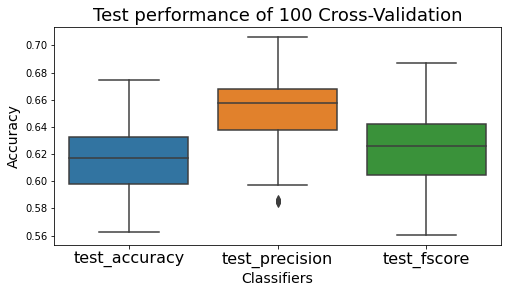

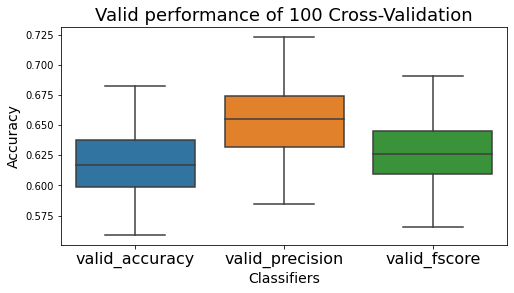

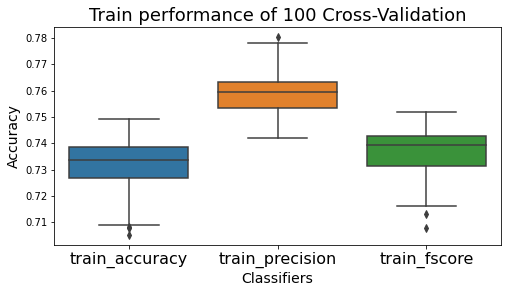

In [ ]:
plt.subplots(figsize=(8,4))
sns.boxplot(data=test_models)
plt.title('Test performance of 100 Cross-Validation',fontsize = 18)
plt.xlabel("Classifiers", fontsize = 14)
plt.ylabel("Accuracy", fontsize = 14)
plt.xticks(fontsize=16, rotation=0)
plt.show()

plt.subplots(figsize=(8,4))
sns.boxplot(data=valid_models)
plt.title('Valid performance of 100 Cross-Validation',fontsize = 18)
plt.xlabel("Classifiers", fontsize = 14)
plt.ylabel("Accuracy", fontsize = 14)
plt.xticks(fontsize=16, rotation=0)
plt.show()

plt.subplots(figsize=(8,4))
sns.boxplot(data=train_models)
plt.title('Train performance of 100 Cross-Validation',fontsize = 18)
plt.xlabel("Classifiers", fontsize = 14)
plt.ylabel("Accuracy", fontsize = 14)
plt.xticks(fontsize=16, rotation=0)
plt.show()

# **Save the model**

In [ ]:
dat_hour = datetime.now().strftime("%d_%b_%Y_%H:%M")
pickle.dump(Model_Grid, open(G_save + 'CNN_60x45_Best_Grid_'+dat_hour, 'wb'))
pickle.dump(Model_CV, open(G_save + 'CNN_60x45_Best_CV_'+dat_hour, 'wb'))

# **Save Grid search-Cross Validation Details**

In [ ]:
pickle.dump([CNN_Nets, Model_Training], open(G_save + 'CNNs_Network_Training', "wb"))

In [ ]:
dat_hour = datetime.now().strftime("%d_%b_%Y_%H:%M")
pickle.dump(Grid_Details, open(G_save + 'Grid_Details_'+dat_hour, 'wb'))
pickle.dump(CNN_CV_Details, open(G_save + 'CNN_CV_Details_'+dat_hour, 'wb'))

Grid_Details.to_csv(G_save + 'Grid_Details_'+dat_hour +'.csv')
CNN_CV_Details.to_csv(G_save + 'CNN_CV_Details_'+dat_hour+ '.csv')